In [1]:
from faker import Faker

import pandas as pd
import numpy as np
import seaborn as sns

import os
import datetime as dt
from tqdm import tqdm

# Setup Faker and Random Seeds

In [2]:
fake = Faker('en_US')
Faker.seed(42)
np.random.seed(43)

# Tweak Parent Distributions

In [3]:
p_null_end_date = 0.1

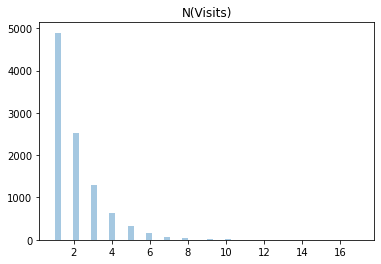

In [4]:
p_n_visits = 0.5
sns.distplot(np.random.geometric(p=p_n_visits, size=10000), kde=False).set_title('N(Visits)');

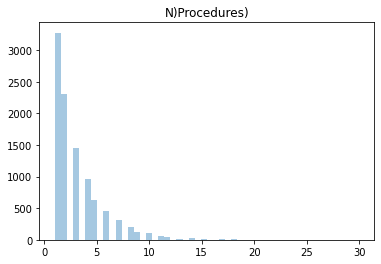

In [5]:
p_n_procedures = 0.33
mean_n_procedures = 1/p_n_procedures # for geometric distribution
sns.distplot(np.random.geometric(p=p_n_procedures, size=10000), kde=False).set_title('N)Procedures)');

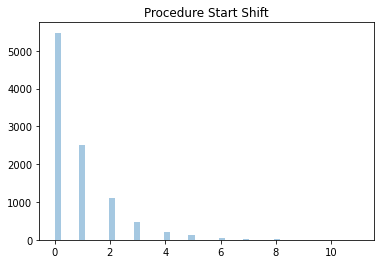

In [6]:
p_procedure_start_shift = 0.55
sns.distplot(np.random.geometric(p=p_procedure_start_shift, size=10000)-1, kde=False).set_title('Procedure Start Shift');

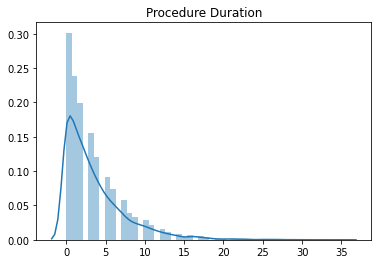

In [7]:
p_procedure_duration = 0.22
sns.distplot(np.random.geometric(p=p_procedure_duration, size=10000)-1).set_title('Procedure Duration');

# Generate Fake Data

In [8]:
n_patients = 10000
rows = []

for i_patient in tqdm(range(n_patients), desc='Patients'):
    patient_key = fake.md5()[0:10]
    for i_visit in range(np.random.geometric(p=p_n_visits)):
        facility_state = fake.state_abbr()
        dt_visit_start = fake.date_between(start_date=dt.date(2018, 1,1), end_date='today')
        n_procedures = np.random.geometric(p=p_n_procedures)
        for i_procedure in range(n_procedures):
            procedure = fake.pystr_format(string_format='{{random_letter}}', letters='ABCDEFGH').upper() # IJKLMNOPQRSTUVWXYZ
            dt_start = dt_visit_start + dt.timedelta(days=np.random.geometric(p=p_procedure_start_shift)-1)

            if np.random.rand() < p_null_end_date:
                dt_end = None
            else:
                # correlate p_procedure_duration by the number of procedures
                # if this visit only has 1 procedure it should be more likely to be a 1 day duration to be realistic (ie outpatient vs multiday inpatient treatment)

                this_p_procedure_duration = p_procedure_duration*( mean_n_procedures / n_procedures )

                # hard code limits on this_p_procedure_duration so it is still valid
                if this_p_procedure_duration < 0.9*p_procedure_duration:
                    this_p_procedure_duration = 0.9*p_procedure_duration
                elif 0.8 < this_p_procedure_duration:
                    this_p_procedure_duration = 0.8

                dt_end = dt_visit_start + dt.timedelta(days=np.random.geometric(p=this_p_procedure_duration)-1)

            rows.append({
                'patient_key': patient_key,
                'facility_state': facility_state,
                'procedure': procedure,
                'service_from': dt_start,
                'service_to': dt_end,
            })

Patients: 100%|██████████| 10000/10000 [00:03<00:00, 2774.89it/s]


In [9]:
dfp = pd.DataFrame(rows)

In [10]:
len(dfp.index)

59818

In [11]:
dfp.head(20)

,patient_key,facility_state,procedure,service_from,service_to
0,6bbeffeb0e,IN,I,2018-12-15,2018-12-13
1,6bbeffeb0e,IN,V,2018-12-17,2018-12-16
2,6bbeffeb0e,OR,L,2018-05-16,2018-05-17
3,6bbeffeb0e,OR,B,2018-05-16,2018-05-16
4,6bbeffeb0e,OR,C,2018-05-17,2018-05-18
5,6bbeffeb0e,OR,B,2018-05-16,2018-05-20
6,6bbeffeb0e,OR,F,2018-05-19,2018-05-21
7,6bbeffeb0e,OR,N,2018-05-16,2018-05-17
8,6bbeffeb0e,OR,O,2018-05-17,2018-05-17
9,6bbeffeb0e,OR,G,2018-05-16,2018-05-24


# Shuffle and Save to CSV

In [12]:
dfp = dfp.sample(frac=1).reset_index(drop=True)

In [13]:
output_path = '../output'
os.makedirs(output_path, exist_ok=True)

dfp.to_csv(f'{output_path}/randomly_generated_service_lines.csv', index=False, na_rep='nan')